In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 20 19:41:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
!pip install torch_utils

  Created wheel for torch-utils: filename=torch_utils-0.1.2-py3-none-any.whl size=6202 sha256=d1d331ca9cbf3ba60e91eb54739f7addea4341a1f9c7c101cc71a12cd32bc178
  Stored in directory: /root/.cache/pip/wheels/5d/c0/1d/a539c1c2a4d41c5d7109899289cded24fe1320b6a6c7b02a4c
Successfully built torch-utils


In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# House Keeping
import os
import glob
from PIL import Image
from timeit import default_timer as timer

# Deep learning tools
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import cuda
from torch.utils.data import TensorDataset, DataLoader, sampler
from torch_utils import AverageMeter
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor
import tqdm

# Data science tools
import numpy as np
import pandas as pd
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Visualizations and Image tools
import cv2
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.util import random_noise
#plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
categories = {0:"Border", 1:"Cat", 2:"Corgi", 3:"Lab", 4:"Dalmatian", 5 :"Golden", 6:"GreyHound", 7:"Husky", 8:"Newfie", 9:"Toller"}

In [7]:
def img_loading(image_list):
  first_img = cv2.imread(image_list[0])
  first_img = cv2.resize(first_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  fist_img = np.asarray(first_img)
  imgs_resized = np.expand_dims((first_img), axis = 0)
  
  return imgs_resized

In [15]:
image_dir = "/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Data/zReal_Pets/Apollo/Apollo.jpg"
image = glob.glob(image_dir)
image = img_loading(image)

test_x = image
test_x = test_x.transpose(0, 3, 1, 2)

# Transfer the data from numpy to tensor
data = {
    'test':
    TensorDataset(torch.from_numpy(test_x))
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'test': DataLoader(data['test'], batch_size = 1, num_workers=1),     
}

testloader = dataloaders["test"]

In [9]:
%%capture

class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = models.densenet121(pretrained=True)
        
        
        # add the average global pool
        self.global_avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
                                    nn.Linear(num_ftrs, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 150),
                                    nn.ReLU(),
                                    nn.Linear(150, 25),
                                    nn.ReLU(),
                                    nn.Linear(25, 10))
        
        self.densenet.load_state_dict(torch.load(("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Best_Pet_Classifier.pt")))
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.densenet.features(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1, 1024))
        x = self.densenet.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.densenet.features(x)

In [10]:
model = DenseNet()
model.eval()
model.cuda()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

DenseNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

DenseNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

Text(0.5, 1.0, 'Cat')

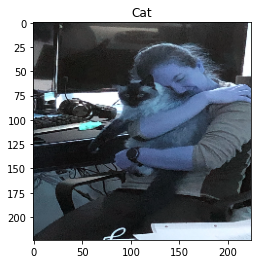

In [16]:
testiter = iter(dataloaders['test'])
dataiter = iter(testiter)
images = dataiter.next()[0]
outputs = model(images.cuda().float())


plt.imshow(images.numpy().squeeze().transpose(1, 2, 0))
plt.title(categories.get(outputs.argmax(dim=1).item()))
plt.show()

In [17]:
# get the gradient of the output with respect to the parameters of the model
outputs[:,2].backward()

# pull the gradients out of the model
gradients = model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model.get_activations(images.cuda().float()).detach()

# weight the channels by corresponding gradients
for i in range(672):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

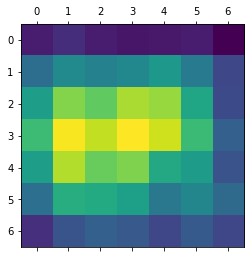

In [18]:
# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap.cpu(), 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [19]:
img = cv2.imread(image_dir)
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite("/content/gdrive/MyDrive/Colab_Notebooks/Deep_Learning/Pet_Classifier/Heatmap.jpeg", superimposed_img)

True